In [18]:
PROCESSES_COUNT = 32

print("Importing...")
from multiprocessing import Pool

import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 10 result folders
Loading data with 32 processes...


100%|██████████| 10/10 [00:00<00:00, 36.97it/s]


In [19]:
# PLOT SETTINGS:
FAST_REACTOR = True # True if epithermal, False if thermal
NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

folder_name = f"plots-{NEUTRON_TEMP}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["fast_reactor"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

df.head()

,k-eff,k-eff-std,result_path,fast_reactor,neutron_temp,partition_text,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
0,0.689670,0.000217,../results/RUNDATA_R5_1,True,EPITHERMAL,FULL,30000,300,50,1.676554e+09,1.676554e+09,97.802,None,0.031421,-0.449969,0.000456,-44996.935536,45.558848,0.101249
1,0.691699,0.000211,../results/RUNDATA_R5_2,True,EPITHERMAL,FULL,30000,300,50,1.676554e+09,1.676554e+09,100.944,None,0.030474,-0.445716,0.000441,-44571.625757,44.056870,0.098845
2,0.691167,0.000224,../results/RUNDATA_R5_3,True,EPITHERMAL,FULL,30000,300,50,1.676554e+09,1.676554e+09,95.929,None,0.032367,-0.446829,0.000468,-44682.914177,46.829777,0.104805
3,0.690498,0.000221,../results/RUNDATA_R5_4,True,EPITHERMAL,FULL,30000,300,50,1.676554e+09,1.676554e+09,96.084,None,0.032022,-0.448230,0.000464,-44822.976625,46.375707,0.103464
4,0.691064,0.000214,../results/RUNDATA_R5_5,True,EPITHERMAL,FULL,30000,300,50,1.676554e+09,1.676554e+09,94.386,None,0.030975,-0.447044,0.000448,-44704.441510,44.821644,0.100262


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

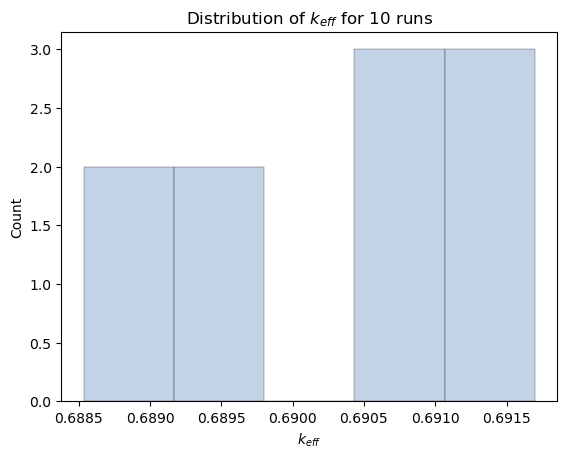

In [20]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

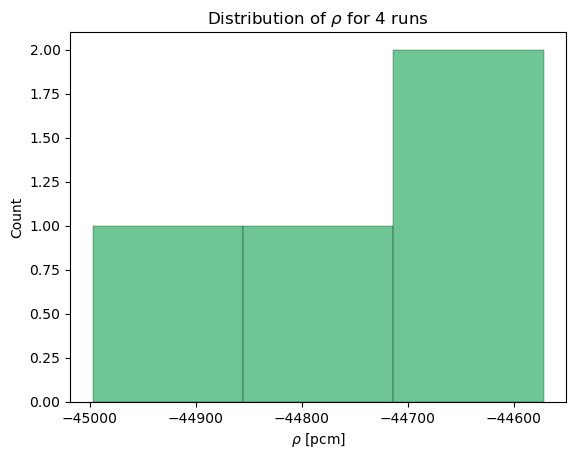

In [ ]:
fig = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                        fit_gaussian=True, decimals=0,
                                        title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-rho"))